In [1]:
import os
import io
import zipfile
import json
import re
import urllib

import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from IPython.display import display, HTML

## Load Death Counts from CDC

Data pulled from:

https://data.cdc.gov/NCHS/Weekly-counts-of-deaths-by-jurisdiction-and-age-gr/y5bj-9g5w

## Basic Processing and Data Preparation

In [2]:
# Load data from the CDC which show weekly death counts by state and age group.

data_url = "https://data.cdc.gov/api/views/y5bj-9g5w/rows.csv?accessType=DOWNLOAD"
with urllib.request.urlopen(data_url) as fh:
    deaths_df = pd.read_csv(fh)

deaths_df['Week Ending Date'] = pd.to_datetime(deaths_df['Week Ending Date'])

deaths_df['Week'] = deaths_df['Week Ending Date'].dt.weekofyear
deaths_df['Year'] = deaths_df['Week Ending Date'].dt.year
deaths_df['Month'] = deaths_df['Week Ending Date'].dt.month

## Determine Which Weeks Haven't Fully Reported Yet.

It looks like there should be at least 570 reported entries for a week.

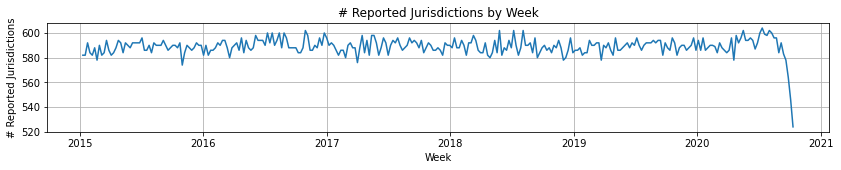

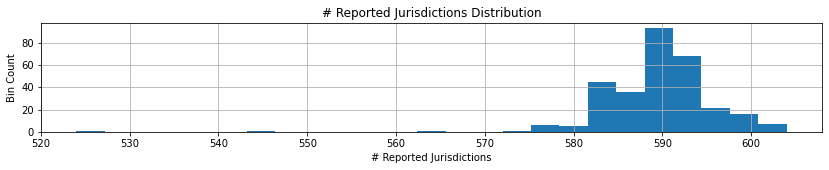

In [3]:
week_counts = deaths_df.groupby('Week Ending Date').size().reset_index().rename(columns={0: 'Count'})

plt.figure(figsize=(14, 2))
plt.title("# Reported Jurisdictions by Week")
plt.plot(week_counts['Week Ending Date'], week_counts['Count'])
plt.xlabel("Week")
plt.ylabel("# Reported Jurisdictions")
plt.grid(1)
plt.show()

plt.figure(figsize=(14, 2))
plt.title("# Reported Jurisdictions Distribution")
week_counts.Count.hist(bins=25)
plt.xlabel("# Reported Jurisdictions")
plt.ylabel("Bin Count")
plt.grid(1)
plt.show()

In [4]:
required_jurisdictions_reported = 570

fully_reported_weeks = week_counts[week_counts.Count >= required_jurisdictions_reported]['Week Ending Date'].unique()

print("Weeks partially reported")
week_counts[week_counts.Count < required_jurisdictions_reported]

Weeks partially reported


,Week Ending Date,Count
298,2020-09-26,564
299,2020-10-03,546
300,2020-10-10,524


## Clean and Filter

1. Only look at reported values, don't take predictions (Type == 'Unweighted')
2. Use the US jurisdiction, don't need at individual state breakdowns.
3. Filter out suppressed death counts due to undereporting.
4. Filter out weeks which haven't been fully reported yet.


In [5]:
# Filter out the rows that were 1) predictions and not actuals, 2) supressed due to data still coming in 3) Include only US, don't look at states individually yet.
deaths_df_cl = deaths_df[
    (deaths_df.Type == 'Unweighted') &
    (deaths_df.Suppress.isnull()) &
    (deaths_df['State Abbreviation'] == 'US') &
    (deaths_df['Week Ending Date'].isin(fully_reported_weeks))
].copy()

# Add fields for the month and year.
deaths_df_cl['Month'] = deaths_df_cl['Week Ending Date'].apply(lambda wed: wed.month)
deaths_df_cl['Year'] = deaths_df_cl['Week Ending Date'].apply(lambda wed: wed.year)

# Add the cumulative total in that year for the given age group.
def year_ag_cumulative(df):
    df = df.sort_values(by='Week').copy()
    df['Number of Deaths Cumulative'] = df['Number of Deaths'].cumsum()
    return df

deaths_df_cl = deaths_df_cl.groupby(['Year', 'Age Group']).apply(year_ag_cumulative).reset_index(drop=True)

## Graph Death Rate By Week / Age Group

Shows the death rates by week in the year for each age group.

2020 shows more deaths that the previous years for all age groups, except for those under 25.

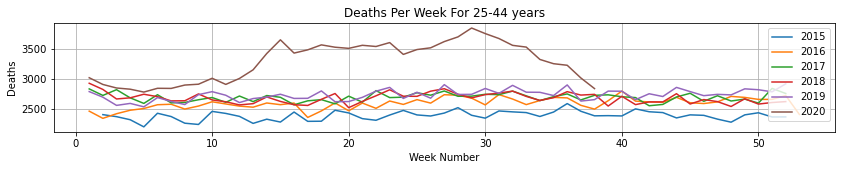

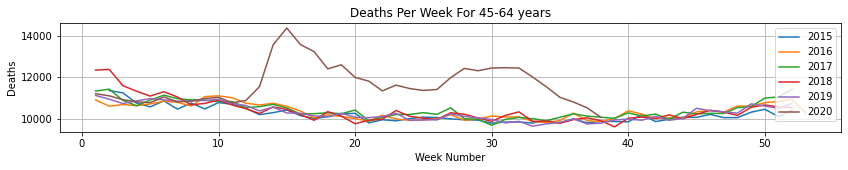

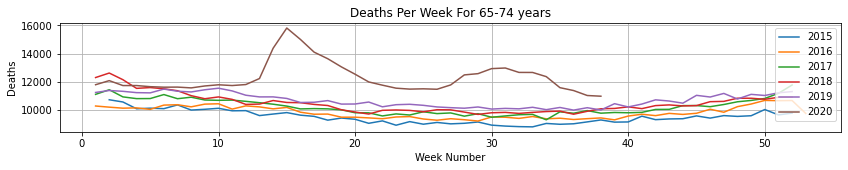

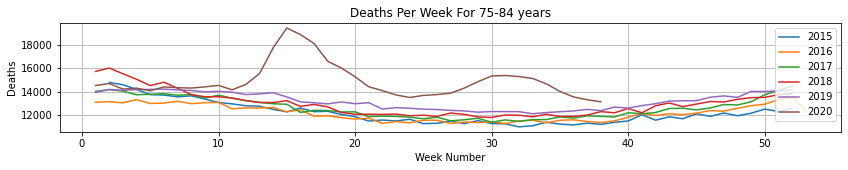

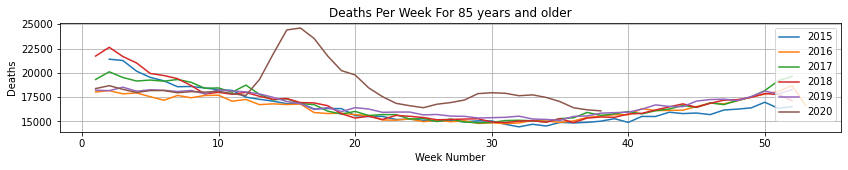

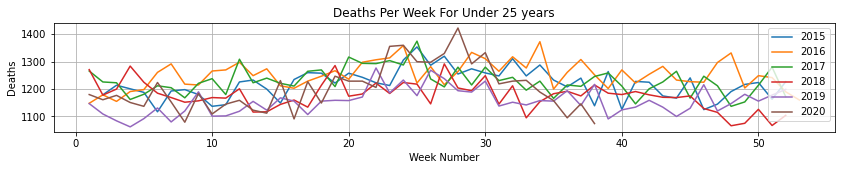

In [6]:
for ag, ag_df in deaths_df_cl.groupby('Age Group'):
    plt.figure(figsize=(14, 2))
    plt.title(f"Deaths Per Week For {ag}")
    for year, year_df in ag_df.groupby('Year'):
        year_df = year_df.sort_values(by='Week')
        plt.plot(year_df.Week, year_df['Number of Deaths'], label=year)
    plt.grid()
    plt.ylabel("Deaths")
    plt.xlabel("Week Number")
    plt.legend()
    plt.show()

### Compute Differences between 2020 and Recent Years

Compute the difference by week and age group between 2020 and the average of the previous years.

In [7]:
# View which years we are looking at 2015 to 2020.
deaths_df_cl.Year.unique()

array([2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [8]:
# Get the difference in the number of cumulative deaths between 2020 and the average for the years 2015-2019

deaths_by_week_ag_pre_2020 = (
    deaths_df_cl[deaths_df_cl.Year < 2020]
        .groupby(['Age Group', 'Week'])
        .agg({'Number of Deaths Cumulative': 'mean'})
        .reset_index())

deaths_by_week_ag_in_2020 = (
    deaths_df_cl[deaths_df_cl.Year == 2020]
        .groupby(['Age Group', 'Week'])
        .agg({'Number of Deaths Cumulative': 'mean'})
        .reset_index())

deaths_by_week_ag_comp = pd.merge(
    deaths_by_week_ag_pre_2020,
    deaths_by_week_ag_in_2020,
    on=['Age Group', 'Week'],
    suffixes=('_pre_2020', '_in_2020'))

deaths_by_week_ag_comp['Number of Deaths Diff'] = (
    deaths_by_week_ag_comp['Number of Deaths Cumulative_in_2020'] -
    deaths_by_week_ag_comp['Number of Deaths Cumulative_pre_2020'])

deaths_by_week_ag_comp.sample(3)

,Age Group,Week,Number of Deaths Cumulative_pre_2020,Number of Deaths Cumulative_in_2020,Number of Deaths Diff
8,25-44 years,9,22787.8,25946.0,3158.2
186,85 years and older,35,582250.2,653418.0,71167.8
195,Under 25 years,6,6853.8,7030.0,176.2


## View Difference Between 2020 and Recent Years.


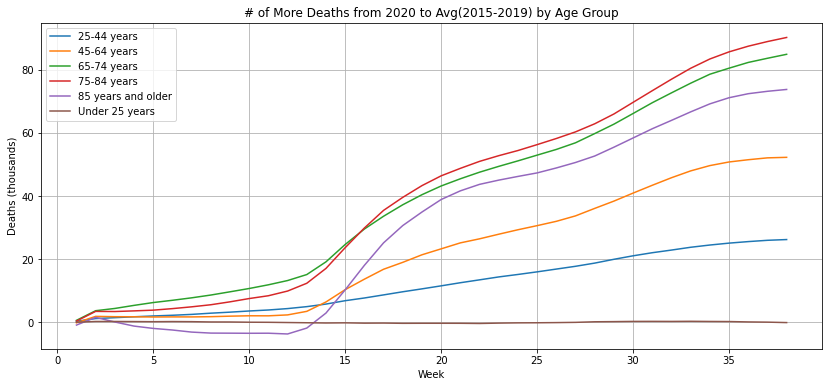

In [9]:
plt.figure(figsize=(14, 6))
for ag, ag_df in deaths_by_week_ag_comp.groupby(['Age Group']):
    plt.plot(ag_df.Week, ag_df['Number of Deaths Diff'] / 1000, label=ag)
    
plt.title("# of More Deaths from 2020 to Avg(2015-2019) by Age Group")
plt.ylabel("Deaths (thousands)")
plt.xlabel("Week")
plt.legend()
plt.grid()
plt.show()

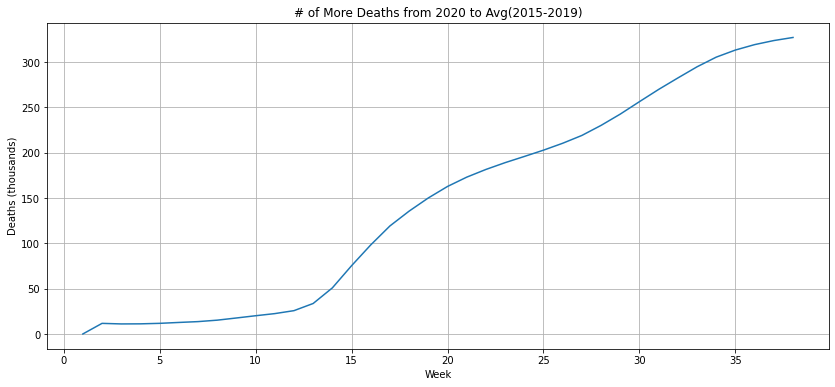

In [10]:
all_age_groups_comp = (deaths_by_week_ag_comp
    .groupby('Week')
    .agg({'Number of Deaths Cumulative_pre_2020': 'sum', 'Number of Deaths Cumulative_in_2020': 'sum'})
    .reset_index())

all_age_groups_comp['Number of Deaths Diff'] = all_age_groups_comp['Number of Deaths Cumulative_in_2020'] - all_age_groups_comp['Number of Deaths Cumulative_pre_2020']

plt.figure(figsize=(14, 6))
plt.title("# of More Deaths from 2020 to Avg(2015-2019)")
plt.plot(all_age_groups_comp['Week'], all_age_groups_comp['Number of Deaths Diff'] / 1000)
plt.xlabel("Week")
plt.ylabel("Deaths (thousands)")
plt.grid(1)

## Is the ratio of deaths in a given week compares to the average number of deaths for the week of year correlated with the Covid pandemic?

This section calculates the ratio of deaths in the week of the year to the average between 2015 and 2020.
That ratio is compared to pre-covid (before 2020-03) and during covid. Histograms are shown and a Pearson correlation
coeefficient is calculated.


In [11]:
all_death_counts_by_week = deaths_df_cl.groupby('Week Ending Date').agg({'Number of Deaths': 'sum'}).reset_index()
all_death_counts_by_week['DuringCovid'] = all_death_counts_by_week['Week Ending Date'] >= pd.Timestamp(2020, 3, 1)

all_death_counts_by_week['Week'] = all_death_counts_by_week['Week Ending Date'].dt.weekofyear
all_death_counts_by_week['Year'] = all_death_counts_by_week['Week Ending Date'].dt.year
all_death_counts_by_week['Month'] = all_death_counts_by_week['Week Ending Date'].dt.month

# Get the average by week number in year.
all_death_counts_by_week_avg = all_death_counts_by_week.groupby('Week').agg({'Number of Deaths': 'mean'}).reset_index()

# join in averages and get difference from average
all_death_counts_by_week = pd.merge(
    all_death_counts_by_week,
    all_death_counts_by_week_avg.rename(columns={'Number of Deaths': 'Avg Number of Deaths'}))


all_death_counts_by_week['Ratio of Deaths To Avg'] = all_death_counts_by_week['Number of Deaths'] / all_death_counts_by_week['Avg Number of Deaths']

Display the average number of deaths by week of the year. We do expect the number of deaths to be affected by season.

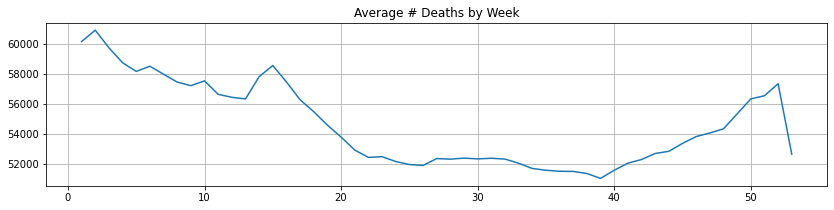

In [12]:
plt.figure(figsize=(14, 3))
plt.title("Average # Deaths by Week")
plt.plot(all_death_counts_by_week_avg['Week'], all_death_counts_by_week_avg['Number of Deaths'])
plt.grid(1)
plt.show()

Plot histograms showing the ratios of deaths to average. During covid death ratios are higher.

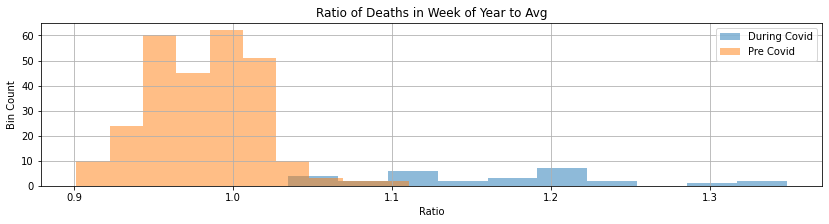

In [13]:
plt.figure(figsize=(14, 3))
plt.title("Ratio of Deaths in Week of Year to Avg")
plt.hist(all_death_counts_by_week[all_death_counts_by_week.DuringCovid]['Ratio of Deaths To Avg'], bins=10, label="During Covid", alpha=0.5)
plt.hist(all_death_counts_by_week[~all_death_counts_by_week.DuringCovid]['Ratio of Deaths To Avg'], bins=10, label="Pre Covid", alpha=0.5)

plt.xlabel("Ratio")
plt.ylabel("Bin Count")
plt.legend()
plt.grid(1)
plt.show()

There is fairly high positive correlation between the ratio of deths to average and the Covid pandemic.
The p_value is very low, meaning that the correlation seen is highly unlikely due to random fluctuations.

In [14]:
corr_coefficient, p_value = pearsonr(all_death_counts_by_week.DuringCovid.astype(int), all_death_counts_by_week['Ratio of Deaths To Avg'])
print(f"Pearson correlation: {corr_coefficient}")
print(f"P-Value: {p_value}")

Pearson correlation: 0.7910522752432207
P-Value: 3.912454997160418e-65
